In [40]:
import os
from sklearn.decomposition import FastICA, PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from osgeo import gdal
import rasterio
from scipy.interpolate import interp2d
from numpy.ma import masked_array
import glob
import h5py

# this is Andrew Watson's library of functions, see https://github.com/Active-Tectonics-Leeds/interseismic_practical
import sys
#sys.path.append('/nfs/a285/homes/eejap/plots/gnss_insar_ts')
import interseis_lib as lib

In [41]:
asc_wd = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/tehran_data/Western_Tehran_Plain_028A_05385_191813_ml2"
desc_wd = "/gws/nopw/j04/nceo_geohazards_vol1/projects/COMET/eejap002/ica_data/tehran_data/Western_Tehran_Plain_035D_05397_131013_ml2"
par_file_asc = os.path.join(asc_wd,'EQA.dem_par')
par_file_desc = os.path.join(desc_wd,'EQA.dem_par')

pattern = os.path.join(asc_wd,'*cum.h5')
matching_files = glob.glob(pattern)
asc_cum_path = matching_files[0]

pattern = os.path.join(desc_wd,'*cum.h5')
matching_files = glob.glob(pattern)
desc_cum_path = matching_files[0]

In [42]:
# Import cum files 
with h5py.File(asc_cum_path, 'r') as file:
    imdates = file['imdates']
    asc_imdates = imdates[:] 
    vel = file['vel']
    asc_vel = vel[:]
    cum = file['cum']
    asc_cum = cum[:]

with h5py.File(desc_cum_path, 'r') as file:
    imdates = file['imdates']
    desc_imdates = imdates[:] 
    vel = file['vel']
    desc_vel = vel[:]
    cum = file['cum']
    desc_cum = cum[:]
    for key in file.keys():
        print(key)

E.geo
N.geo
U.geo
bperp
coh_avg
corner_lat
corner_lon
cum
gap
hgt
imdates
maxTlen
n_gap
n_ifg_noloop
n_loop_err
n_unw
post_lat
post_lon
refarea
resid_rms
slc.mli
vel
vintercept


In [43]:
#calc below, long and tedious

width_asc = int(lib.get_par(par_file_asc,'width'))
length_asc = int(lib.get_par(par_file_asc,'nlines'))

width_desc = int(lib.get_par(par_file_desc,'width'))
length_desc = int(lib.get_par(par_file_desc,'nlines'))

# get corner positions
corner_lat_asc = float(lib.get_par(par_file_asc, 'corner_lat'))
corner_lon_asc = float(lib.get_par(par_file_asc,'corner_lon'))

corner_lat_desc = float(lib.get_par(par_file_desc,'corner_lat'))
corner_lon_desc = float(lib.get_par(par_file_desc,'corner_lon'))

# get post spacing (distance between velocity measurements)
post_lat_asc = float(lib.get_par(par_file_asc,'post_lat'))
post_lon_asc = float(lib.get_par(par_file_asc,'post_lon'))

post_lat_desc = float(lib.get_par(par_file_desc,'post_lat'))
post_lon_desc = float(lib.get_par(par_file_desc,'post_lon'))

# calculate grid spacings
lat_asc = corner_lat_asc + post_lat_asc*np.arange(1,length_asc+1) - post_lat_asc/2
lon_asc = corner_lon_asc + post_lon_asc*np.arange(1,width_asc+1) - post_lon_asc/2

lat_desc = corner_lat_desc + post_lat_desc*np.arange(1,length_desc+1) - post_lat_desc/2
lon_desc = corner_lon_desc + post_lon_desc*np.arange(1,width_desc+1) - post_lon_desc/2

In [44]:
# cum shape is (t, lat, lon)
# we want to make an array of (pixels, time)
# we want to reshape cum (202, 268, 327) into (202,(268*327))
asc_cum_shape = asc_cum.shape
n_pix = asc_cum_shape[1] * asc_cum_shape[2]
asc_cum_reshape = (asc_cum_shape[0], n_pix)

asc_cum_ = np.reshape(asc_cum, asc_cum_reshape)

desc_cum_shape = desc_cum.shape
n_pix = desc_cum_shape[1] * desc_cum_shape[2]
desc_cum_reshape = (desc_cum_shape[0], n_pix)

desc_cum_ = np.reshape(desc_cum, desc_cum_reshape)

# cum_ arrays are (pixels,time)
print(asc_cum.shape)
print(desc_cum.shape)

(207, 698, 933)
(202, 698, 933)


In [45]:
# Check if there are any NaN values in your data_array
has_nans = np.isnan(desc_cum_).any()

if has_nans:
    print("Desc data contains NaN values.")
else:
    print("Desc data does not contain NaN values.")

# Check if there are any zero values in your data_array
has_zeroes = (desc_cum_ == 0).any()

if has_zeroes:
    print("Desc data contains zero values.")
else:
    print("Desc data does not contain zero values.")

# for asc
has_nans = np.isnan(asc_cum_).any()

if has_nans:
    print("Asc data contains NaN values.")
else:
    print("Asc data does not contain NaN values.")

# Check if there are any zero values in your data_array
has_zeroes = (asc_cum_ == 0).any()

if has_zeroes:
    print("Asc data contains zero values.")
else:
    print("Asc data does not contain zero values.")

Desc data contains NaN values.
Desc data contains zero values.
Asc data contains NaN values.
Asc data contains zero values.


Text(0, 0.5, 'time (ifgs)')

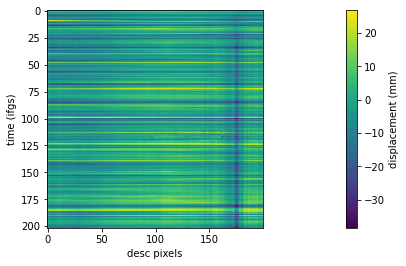

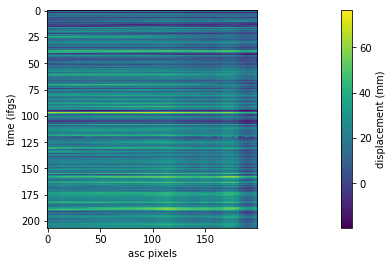

In [46]:
plt.figure(figsize=(30,4))

plt.imshow(desc_cum_[:,1000:1200])
plt.colorbar(label='displacement (mm)')
plt.xlabel('desc pixels')
plt.ylabel('time (ifgs)')

plt.figure(figsize=(30,4))

plt.imshow(asc_cum_[:,1000:1200])
plt.colorbar(label='displacement (mm)')
plt.xlabel('asc pixels')
plt.ylabel('time (ifgs)')

In [47]:
# Print how many NaNs there are
nan_indices = np.argwhere(np.isnan(desc_cum_))
print('There are {} desc NaNs'.format(nan_indices.shape[0]))
print('Desc data with NaNs shape', desc_cum_.shape)

# find rows containing NaNs
nan_pixels_desc = np.any(np.isnan(desc_cum_), axis=0)

# create a new data array without nan columns (pixels)
desc_cum_no_nans = desc_cum_[:, ~nan_pixels_desc]
print('Desc data shape', desc_cum_no_nans.shape)

# remove nan rows (ifgs)
#nan_pixels_rows = np.any(np.isnan(desc_cum_), axis=1)
#desc_cum_no_nans = desc_cum_[~nan_pixels_rows, :]

# print number of remaining pixels
#print(desc_cum_no_nans.shape)

# for ascending
# Print how many NaNs there are
nan_indices = np.argwhere(np.isnan(asc_cum_))
print('There are {} asc NaNs'.format(nan_indices.shape[0]))
print('Asc data with NaNs shape', asc_cum_.shape)

# find rows containing NaNs
nan_pixels_asc = np.any(np.isnan(asc_cum_), axis=0)

# create a new data array without nan columns (pixels)
asc_cum_no_nans = asc_cum_[:, ~nan_pixels_asc]
print('Asc data shape', asc_cum_no_nans.shape)

# remove nan rows (ifgs)
#nan_pixels_rows = np.any(np.isnan(desc_cum_), axis=1)
#desc_cum_no_nans = desc_cum_[~nan_pixels_rows, :]

# print number of remaining pixels
#print(desc_cum_no_nans.shape)

There are 1522858 desc NaNs
Desc data with NaNs shape (202, 651234)
Desc data shape (202, 615471)
There are 1960799 asc NaNs
Asc data with NaNs shape (207, 651234)
Asc data shape (207, 627961)


Text(0, 0.5, 'time (ifgs)')

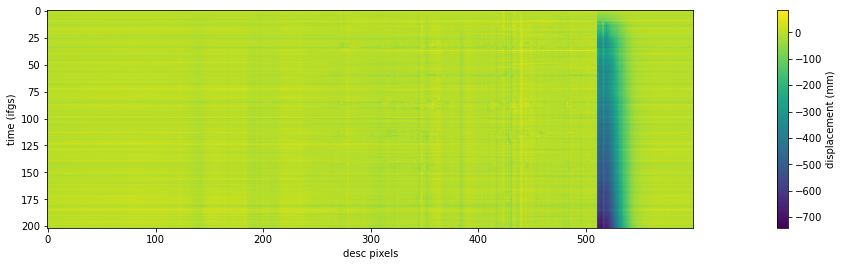

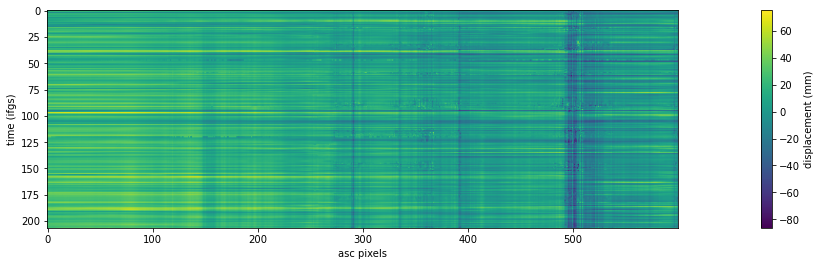

In [48]:
plt.figure(figsize=(30,4))

plt.imshow(desc_cum_no_nans[:,100:700])
plt.colorbar(label='displacement (mm)')
plt.xlabel('desc pixels')
plt.ylabel('time (ifgs)')

plt.figure(figsize=(30,4))

plt.imshow(asc_cum_no_nans[:,100:700])
plt.colorbar(label='displacement (mm)')
plt.xlabel('asc pixels')
plt.ylabel('time (ifgs)')

In [49]:
has_nans = np.isnan(desc_cum_no_nans).any()

if has_nans:
    print("Desc data contains NaN values.")
else:
    print("Desc data does not contain NaN values.")

# Check if there are any zero values in your data_array
as_zeroes = (desc_cum_no_nans == 0).any()

if has_zeroes:
    print("Desc data contains zero values.")
else:
    print("Desc data does not contain zero values.")

print(desc_cum_no_nans.shape)

# for asc
has_nans = np.isnan(asc_cum_no_nans).any()

if has_nans:
    print("Asc data contains NaN values.")
else:
    print("Asc data does not contain NaN values.")

# Check if there are any zero values in your data_array
as_zeroes = (asc_cum_no_nans == 0).any()

if has_zeroes:
    print("Asc data contains zero values.")
else:
    print("Asc data does not contain zero values.")

print(asc_cum_no_nans.shape)

Desc data does not contain NaN values.
Desc data contains zero values.
(202, 615471)
Asc data does not contain NaN values.
Asc data contains zero values.
(207, 627961)


[[  0.         0.         0.         0.      ]
 [-13.743102 -14.967885 -16.534473 -15.433814]
 [-27.182592 -28.481642 -30.577623 -29.228086]
 [-36.104805 -37.711388 -39.95684  -38.812065]]
-10.22947


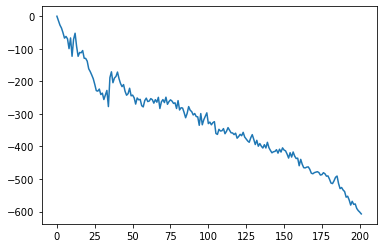

In [50]:
#plt.plot(desc_cum_[:, 0])
plt.plot(desc_cum_no_nans[:, 0])

#print(desc_cum[0:4, 0:4])
print(desc_cum_no_nans[0:4, 0:4])

print(desc_cum_no_nans[25,50])

### Descending frame

In [51]:
# attempt ICA
ncomponents=3

desc = desc_cum_no_nans # choose original data with nan_to_num, data with nans removed, or data with nans removed and cumulative

# set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
ica = FastICA(n_components=ncomponents, whiten="unit-variance")

# fit the transformeter to the data array
S_ft = ica.fit_transform(desc) # fit model and recover signals
S_t = ica.transform(desc) # recover sources from x using unmixing matrix
## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_transform


In [52]:
# ica result has objects whitening matrix and mixing matrix

print('Data array shape: {}'.format(desc.shape))
print('ICA component matrix shape: {}'.format(S_ft.shape))
print('Whitening matrix shape:{}'.format(ica.whitening_.shape))
print('Mixing matrix shape: {}'.format(ica.mixing_.shape))

Data array shape: (202, 615471)
ICA component matrix shape: (202, 3)
Whitening matrix shape:(3, 615471)
Mixing matrix shape: (615471, 3)


In [53]:
# For comparison, compute PCA
pca = PCA(n_components=ncomponents)
H = pca.fit_transform(desc)  # Reconstruct signals based on orthogonal components

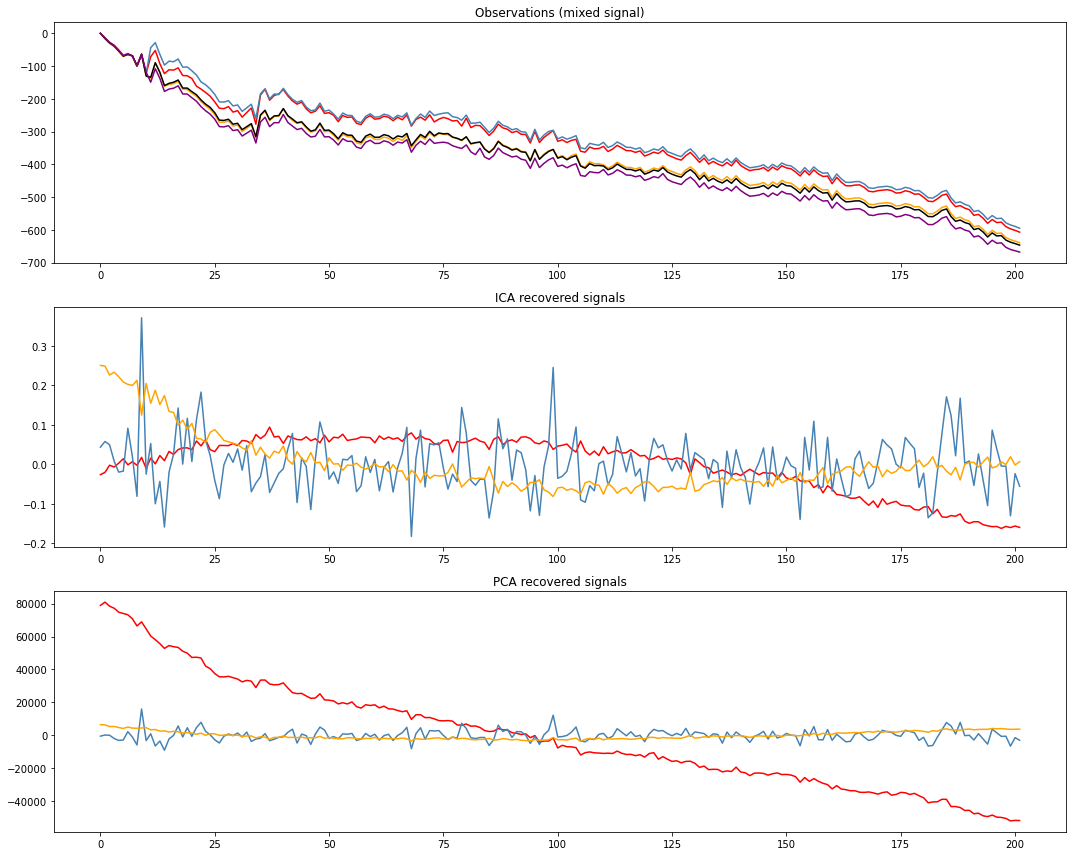

In [54]:
# plot results

plt.figure(figsize=(15,12))

models = [desc, S_ft, H]
names = [
    "Observations (mixed signal)",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange", "black", "purple"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [55]:
# from here: https://gist.github.com/Tetraquark/5bf052134d413f79748ce3aceaaf42df
restored_signals = []

# Nullify independent components of signal 1 and signal 2  
for j in range(ncomponents):
    S_j = np.copy(S_ft)
    for i in range(len(S_j)):
        (S_j)[i,j] = 0
    restored_signal_j = np.dot(S_j, ica.mixing_.T)
    #for i in range(len(restored_signal_j)):
     #   restored_signal_j[i,j] = 0
        
    # Append the restored signal to the list
    restored_signals.append(restored_signal_j)
    print(restored_signal_j.shape)

# Access the restored signals
print("Number of Restored Signals:", len(restored_signals))
for i, restored_signal in enumerate(restored_signals, start=1):
    print(f"Restored Signal {i} Shape:\n{restored_signal.shape}")

(202, 615471)
(202, 615471)
(202, 615471)
Number of Restored Signals: 3
Restored Signal 1 Shape:
(202, 615471)
Restored Signal 2 Shape:
(202, 615471)
Restored Signal 3 Shape:
(202, 615471)


In [ ]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

# Plot each restored signal on a separate subplot
for i, restored_signal in enumerate(restored_signals, start=1):
    axes[i - 1].grid()
    axes[i - 1].set_xlim([0, len(restored_signal)])
    axes[i - 1].plot(restored_signal)
    axes[i - 1].set_title(f"Restored Signal {i}")

plt.xlabel('Time Step')
plt.show()

In [ ]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(4 * ncomponents, 10))
#fig, axes = plt.subplots(3,2, figsize=(15, 10))

nan_indices = np.argwhere(nan_pixels_desc).flatten()
non_nan_indices = np.argwhere(~nan_pixels_desc).flatten()

# Plot each restored signal in lat, lon on a separate subplot
for i, restored_signal in enumerate(restored_signals, start=1):
    # Create a new matrix with NaNs
    desc_cum_with_nans = np.full((desc_cum_shape[2] * desc_cum_shape[1],), np.nan)

    # Assign values from the restored signal to non-NaN positions
    desc_cum_with_nans[non_nan_indices] = restored_signal[-1]

    desc_cum_with_nans_reshaped = desc_cum_with_nans.reshape((desc_cum_shape[1], desc_cum_shape[2]))

    lon, lat = np.meshgrid(lon_desc, lat_desc)

    # Plot on the subplot
    im = axes[i - 1].imshow(desc_cum_with_nans_reshaped, extent=(lon_desc.min(), lon_desc.max(), lat_desc.min(), lat_desc.max()), cmap='viridis', interpolation ='none')
    axes[i - 1].set_xlabel('Longitude')
    axes[i - 1].set_ylabel('Latitude')
    axes[i - 1].set_title(f'Restored Signal {i}')
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i - 1], label='Deformation Values')

plt.tight_layout()
plt.show()

### Ascending Frame

In [20]:
# asc ICA
ncomponents=3

asc = asc_cum_no_nans # choose original data with nan_to_num, data with nans removed, or data with nans removed and cumulative

# set up the transformer (ica). In MATLAB you do the whitening first then the transforming, here you do it in one.
ica = FastICA(n_components=ncomponents, whiten="unit-variance")

# fit the transformeter to the data array
S_ft = ica.fit_transform(asc) # fit model and recover signals
S_t = ica.transform(asc) # recover sources from x using unmixing matrix
## S_ft and S_t results should be identical as ica.transform uses mixing matrix calculated by ica.fit_transform

In [21]:
# ica result has objects whitening matrix and mixing matrix

print('Data array shape: {}'.format(asc.shape))
print('ICA component matrix shape: {}'.format(S_ft.shape))
print('Whitening matrix shape:{}'.format(ica.whitening_.shape))
print('Mixing matrix shape: {}'.format(ica.mixing_.shape))

Data array shape: (207, 435650)
ICA component matrix shape: (207, 3)
Whitening matrix shape:(3, 435650)
Mixing matrix shape: (435650, 3)


In [22]:
# For comparison, compute PCA
pca = PCA(n_components=ncomponents)
H = pca.fit_transform(asc)  # Reconstruct signals based on orthogonal components

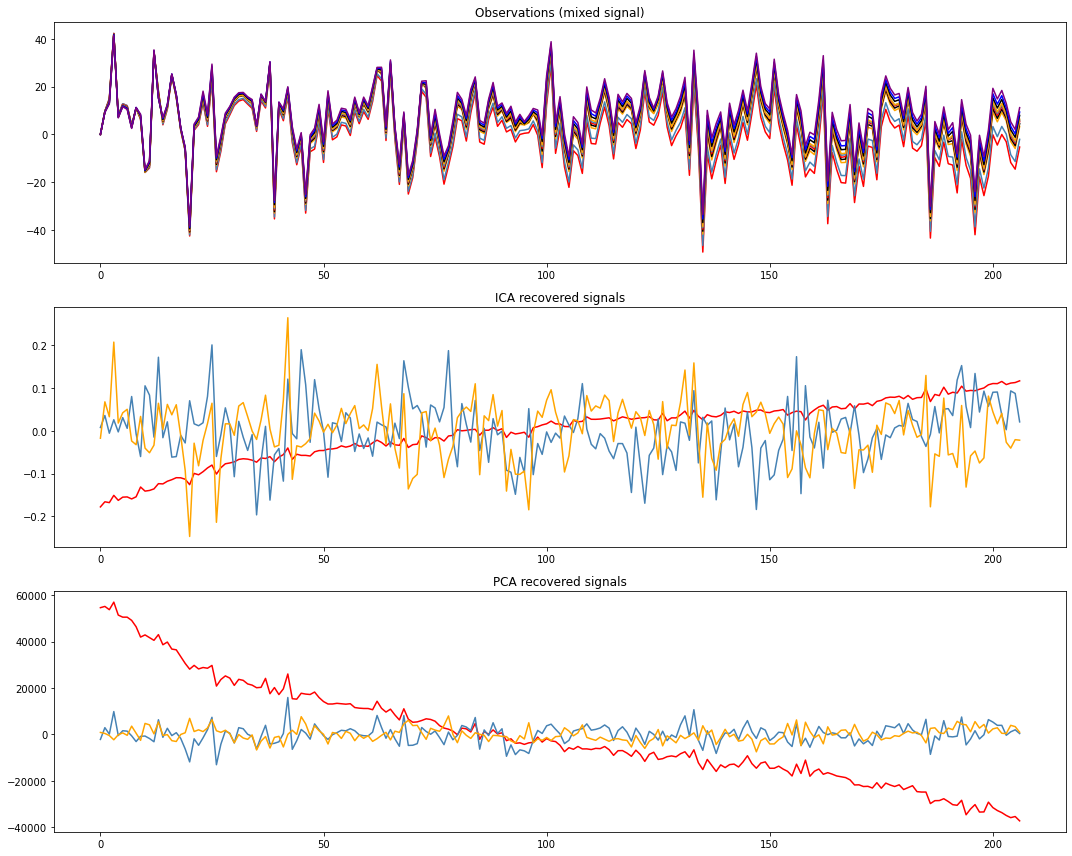

In [23]:
# plot results

plt.figure(figsize=(15,12))

models = [asc, S_ft, H]
names = [
    "Observations (mixed signal)",
    "ICA recovered signals",
    "PCA recovered signals",
]
colors = ["red", "steelblue", "orange", "black","red", "steelblue", "orange", "black","blue","purple"]

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(3, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

In [24]:
# from here: https://gist.github.com/Tetraquark/5bf052134d413f79748ce3aceaaf42df
restored_signals = []

# Nullify independent components of signal 1 and signal 2  
for j in range(ncomponents):
    S_j = np.copy(S_ft)
    for i in range(len(S_j)):
        (S_j)[i,j] = 0
    restored_signal_j = np.dot(S_j, ica.mixing_.T)
    #for i in range(len(restored_signal_j)):
     #   restored_signal_j[i,j] = 0
        
    # Append the restored signal to the list
    restored_signals.append(restored_signal_j)
    print(restored_signal_j.shape)

# Access the restored signals
print("Number of Restored Signals:", len(restored_signals))
for i, restored_signal in enumerate(restored_signals, start=1):
    print(f"Restored Signal {i} Shape:\n{restored_signal.shape}")

(207, 435650)
(207, 435650)
(207, 435650)
Number of Restored Signals: 3
Restored Signal 1 Shape:
(207, 435650)
Restored Signal 2 Shape:
(207, 435650)
Restored Signal 3 Shape:
(207, 435650)


KeyboardInterrupt: 

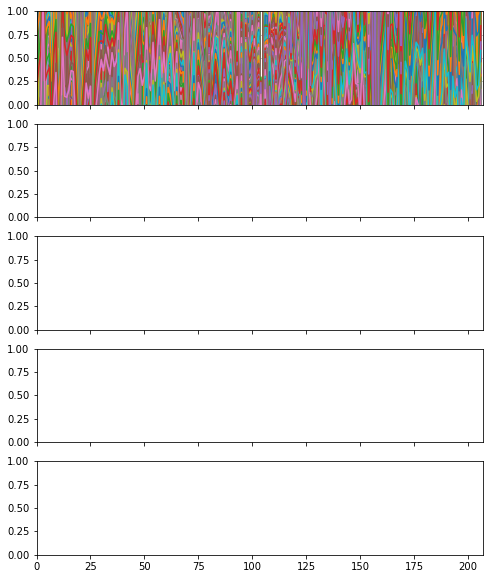

In [19]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1, figsize=(8, 2 * ncomponents), sharex=True)

# Plot each restored signal on a separate subplot
for i, restored_signal in enumerate(restored_signals, start=1):
    axes[i - 1].grid()
    axes[i - 1].set_xlim([0, len(restored_signal)])
    axes[i - 1].plot(restored_signal)
    axes[i - 1].set_title(f"Restored Signal {i}")

plt.xlabel('Time Step')
plt.show()

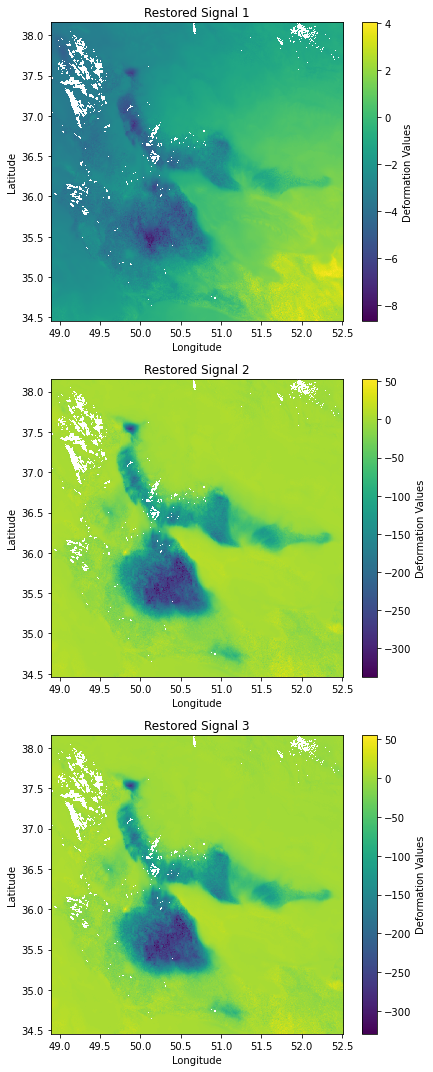

In [25]:
# Create subplots
fig, axes = plt.subplots(ncomponents, 1,figsize=(2 * ncomponents, 15))

nan_indices = np.argwhere(nan_pixels_asc).flatten()
non_nan_indices = np.argwhere(~nan_pixels_asc).flatten()

# Plot each restored signal in lat, lon on a separate subplot
for i, restored_signal in enumerate(restored_signals, start=1):
    # Create a new matrix with NaNs
    asc_cum_with_nans = np.full((asc_cum_shape[2] * asc_cum_shape[1],), np.nan)

    # Assign values from the restored signal to non-NaN positions
    asc_cum_with_nans[non_nan_indices] = restored_signal[-1]

    asc_cum_with_nans_reshaped = asc_cum_with_nans.reshape((asc_cum_shape[1], asc_cum_shape[2]))

    lon, lat = np.meshgrid(lon_asc, lat_asc)

    # Plot on the subplot
    im = axes[i - 1].imshow(asc_cum_with_nans_reshaped, extent=(lon_asc.min(), lon_asc.max(), lat_asc.min(), lat_asc.max()), cmap='viridis', interpolation ='none')
    axes[i - 1].set_xlabel('Longitude')
    axes[i - 1].set_ylabel('Latitude')
    axes[i - 1].set_title(f'Restored Signal {i}')

    # Plot the point at index (92, 83)
    #axes[i - 1].plot(lon_asc[92], lat_asc[83], 'ro', markersize=8, label='Reference point')
    #axes[i - 1].legend()
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i - 1], label='Deformation Values')
plt.tight_layout()
plt.show()